In [52]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fnmatch
from matplotlib.colors import to_rgba

# -----------------------------
# Helpers & config
# -----------------------------

SAMPLER_NAME = {
    "HMC": "HMC",
    "Metro": "Metropolis",
    "DEMetro_Z": "DEMetropolisZ",
    "SMC": "SMC",
}

# Kurze Aliase für Metrik-Spalten
METRIC_MAP = {
    "ws":         "global_median_wasserstein_distance",   # kleiner = besser
    "ws_delta":   "ws_glass_delta",                       # kleiner = besser (Glass Δ)
    "mmd":        "global_median_mmd_rff",                # kleiner = besser
    "mmd_delta":  "mmd_rff_glass_delta",                  # kleiner = besser
    "rt":         "global_median_runtime",                # kleiner = besser
    "ess":        "global_median_ess",                    # größer  = besser
    "mt":         "global_median_mode_transitions",       # interpretationsabhängig
    "mean":  "global_median_mean_rmse",              # kleiner = besser
    "var":   "global_median_var_rmse",               # kleiner = besser
}

def resolve_metric(key_or_name: str) -> str:
    """Erlaubt kurze Keys oder bereits volle Spaltennamen."""
    return METRIC_MAP.get(key_or_name, key_or_name)


def text_color_for(v, im):
    if not np.isfinite(v): 
        return "black"
    r,g,b,a = im.cmap(im.norm(v))
    luminance = 0.299*r + 0.587*g + 0.114*b
    return "black" if luminance > 0.6 else "white"

def load_combo_spec(spec):
    """
    spec: dict, Pfad zu YAML, oder None -> None.
    YAML-Format:
    combos:
      "<Row label>":
        directions:
          "<DirKey>": ["*pattern/*", ...]
        weights: { "<DirKey>": float, ... }    # optional
    """
    if spec is None:
        return None
    if isinstance(spec, dict):
        return spec
    try:
        import yaml
    except ImportError as e:
        raise RuntimeError("combo_spec is a YAML path but PyYAML is not installed. "
                           "Install with `pip install pyyaml` or pass a dict.") from e
    p = Path(spec)
    with p.open("r") as f:
        y = yaml.safe_load(f)
    return y.get("combos", y)

def match_combo(csv_path: Path, combo_spec: dict):
    """
    Finde (row_label, direction_key) für csv_path anhand fnmatch-Patterns.
    Rückgabe: (row_label, direction_key) oder (None, None).
    """
    if not combo_spec:
        return None, None
    text = str(csv_path).replace("\\", "/").lower()
    for row_label, entry in combo_spec.items():
        dirs = (entry.get("directions") or {})
        for dir_key, patterns in dirs.items():
            for pat in (patterns or []):
                if fnmatch.fnmatch(text, pat.lower()):
                    return row_label, dir_key
    return None, None

def reduce_directions(df_dir: pd.DataFrame, mode="mean", goal="low",
                      weights=None, expected_dirs=None):
    """
    df_dir: DataFrame ['Direction','Value'] je (Row,Sampler) nach Level-Aggregation.
    mode : 'mean' | 'worst' | 'weighted'
    goal : 'low' (kleiner besser) | 'high' (größer besser)
    weights: dict {Direction: weight} (nur für 'weighted')
    expected_dirs: Liste der in combo_spec definierten Richtungen (für korrektes k/m)
    Rückgabe: (value, status) mit status="k/m" (#vorhanden / #definiert)
    """
    if df_dir.empty:
        return np.nan, "0/0"

    by_dir = df_dir.groupby('Direction')['Value'].mean()

    if expected_dirs:                      # m = definierte Anzahl
        vals = by_dir.reindex(expected_dirs)   # fehlende Richtungen → NaN
        m_def = len(expected_dirs)
    else:                                  # Fallback: zähle vorhandene
        vals = by_dir
        m_def = len(by_dir)

    k = int(vals.notna().sum())
    status = f"{k}/{int(m_def)}"

    vals = vals.dropna()
    if vals.empty:
        return np.nan, status

    if mode == "mean":
        v = float(vals.mean())
    elif mode == "worst":
        v = float(vals.max() if goal == "low" else vals.min())
    elif mode == "weighted":
        if not weights:
            v = float(vals.mean())
        else:
            w = pd.Series(weights).reindex(vals.index).fillna(0.0)
            if w.sum() == 0:
                v = float(vals.mean())
            else:
                v = float((vals * (w / w.sum())).sum())
    else:
        raise ValueError("dir_reduce must be 'mean' | 'worst' | 'weighted'")

    return v, status

# -----------------------------
# Main generator
# -----------------------------

def generate_heatmaps_for_experiment(
    experiment_path,
    metric="ws_glass_delta",
    fallback_metric="global_median_wasserstein_distance",
    which_results="chain",          # "chain" | "pooled" | None (scan beide)
    agg="median",                   # Aggregation über x-Level innerhalb eines CSVs
    normalize="none",               # "none" | "row"
    combo_spec=None,
    dir_reduce="mean",
    metric_goal="low",
    strict_combos="warn",     # globaler Spec-Coverage-Check
    unmatched_policy="drop",  # <<< 'drop' | 'error' | 'keep_single' (legacy)
    out_subdir="heatmaps",
    save=False,
    cmap="auto",          # "auto" | "green_best" | "red_best" | any mpl cmap name
    cap_max=None,
    vmax_mode="p95",
    show_star=True,          # <<< new
    show_status=True,        # <<< new  (controls "(k/m)")
):
    """
    Baut eine Attribute/Combo × Sampler Heatmap mit optionaler Combo-Spezifikation.
    """
    exp = Path(experiment_path).resolve()
    if not exp.exists():
        raise FileNotFoundError(exp)

    combos = load_combo_spec(combo_spec)

    # 1) CSVs finden
    leafs_all = ("pooled_results", "chain_results")
    if which_results in {"chain", "pooled"}:
        leafs = ({"chain": "chain_results", "pooled": "pooled_results"}[which_results],)
    elif which_results is None:
        leafs = leafs_all
    else:
        raise ValueError("which_results must be 'chain', 'pooled', or None")

    csvs = []
    for leaf in leafs:
        csvs += list(exp.glob(f"**/{leaf}/Global_results_*.csv"))
    if not csvs:
        raise RuntimeError(f"No Global_results_*.csv found under **/{'|'.join(leafs)}/")

    # 1b) Coverage-Check gegen combo_spec (global)
    if combos:
        coverage = {}
        for row_label, entry in combos.items():
            for dir_key in (entry.get("directions") or {}):
                coverage[(row_label, dir_key)] = 0
        for p in csvs:
            row_label, dir_key = match_combo(p, combos)
            if row_label is not None:
                coverage[(row_label, dir_key)] = coverage.get((row_label, dir_key), 0) + 1
        missing = [(r, d) for (r, d), c in coverage.items() if c == 0]
        if strict_combos == "error" and missing:
            msg = "\n".join(f"- {r} :: {d}" for r, d in missing)
            raise RuntimeError(f"combo_spec patterns not matched (possible typos):\n{msg}")
        elif strict_combos == "warn" and missing:
            print("[WARN] combo_spec patterns not matched (ignored):")
            for r, d in missing:
                print(f"  - {r} :: {d}")

    # 2) Lesen & Sammeln
    rows = []
    for csv_path in csvs:
        sampler_key = csv_path.stem.replace("Global_results_", "")
        sampler = SAMPLER_NAME.get(sampler_key)
        if not sampler:
            continue

        df_csv = pd.read_csv(csv_path)
        metric_col = metric if metric in df_csv.columns else (
            fallback_metric if fallback_metric in df_csv.columns else None
        )
        if metric_col is None or df_csv.empty:
            continue

        val = getattr(df_csv[metric_col], agg)()

        row_label, dir_key = match_combo(csv_path, combos) if combos else (None, None)

        if row_label is None:
            # Kein YAML-Match → entscheide nach Policy
            if unmatched_policy == "error":
                raise RuntimeError(f"No combo_spec match for: {csv_path}")
            elif unmatched_policy == "drop":
                continue              # <<< komplett ignorieren
            else:
                # 'keep_single' (legacy): heuristische Single-Zuordnung
                parts = "/".join(s.lower() for s in csv_path.parts)
                if "corr" in parts: row = "Correlation"
                elif "dim" in parts: row = "Dimension"
                elif ("tail" in parts) or ("nu" in parts): row = "Tail weight (ν)"
                elif ("mm" in parts) or ("mode" in parts): row = "Mode distance"
                else: row = "Unknown"
                rows.append({"Row": row, "Direction": "single", "Sampler": sampler, "Value": float(val)})
        else:
            # YAML-Match → übernehmen
            rows.append({
                "Row": row_label, "Direction": dir_key, "Sampler": sampler, "Value": float(val)
            })


    df_rec = pd.DataFrame(rows)

    # 3) Directions je (Row,Sampler) reduzieren -> ein Wert + Status k/m
    combo_rows = df_rec[df_rec['Direction'] != "single"]
    single_rows = df_rec[df_rec['Direction'] == "single"]
    out_records = []

    # Singles
    if not single_rows.empty:
        for (row, sampler), sub in single_rows.groupby(["Row", "Sampler"]):
            v = float(sub["Value"].mean())
            out_records.append({"Row": row, "Sampler": sampler, "Value": v, "Status": "single"})

    # Combos (2/3/4 Richtungen)
    if not combo_rows.empty:
        weights_map = {}
        if combos:
            for row_label, entry in combos.items():
                if "weights" in entry:
                    weights_map[row_label] = entry["weights"]

        for (row, sampler), sub in combo_rows.groupby(["Row", "Sampler"]):
            weights = weights_map.get(row) if weights_map else None
            expected = list(combos[row]["directions"].keys()) if (combos and row in combos) else None
            v, status = reduce_directions(sub[["Direction", "Value"]],
                                          mode=dir_reduce, goal=metric_goal,
                                          weights=weights, expected_dirs=expected)
            out_records.append({"Row": row, "Sampler": sampler, "Value": v, "Status": status})

    df_final = pd.DataFrame(out_records)
    if df_final.empty:
        raise RuntimeError("No rows produced after direction reduction. Check combo_spec and patterns.")

    # 4) Pivot
    desired_cols = ["Metropolis", "DEMetropolisZ", "HMC", "SMC"]
    singles_order = [r for r in ["Dimension", "Correlation", "Tail weight (ν)", "Mode distance"]
                     if r in df_final["Row"].unique()]
    combo_order = sorted([r for r in df_final["Row"].unique() if r not in singles_order])
    row_order = singles_order + combo_order

    pivot = (df_final.pivot(index="Row", columns="Sampler", values="Value")
                      .reindex(index=row_order, columns=desired_cols))
    stat = (df_final.pivot(index="Row", columns="Sampler", values="Status")
                      .reindex(index=row_order, columns=desired_cols))

    # 5) Save tabellen
    out_dir = Path(experiment_path) / out_subdir
    out_dir.mkdir(parents=True, exist_ok=True)
    pivot.to_csv(out_dir / f"pivot_{metric}.csv")
    stat.to_csv(out_dir / f"status_{metric}.csv")

    # 5b) Winners robust (Zeilen mit nur NaN nicht crashen)
    def best_row(r):
        rr = r.dropna()
        if rr.empty:
            return pd.Series({"Best Sampler": "-", "Best Value": np.nan})
        idx = rr.idxmin() if metric_goal == "low" else rr.idxmax()
        return pd.Series({"Best Sampler": idx, "Best Value": rr.loc[idx]})
    winners = pivot.apply(best_row, axis=1)
    winners.to_csv(out_dir / f"winners_{metric}.csv")

    # 6) Farbgrenzen (robust) & Clipping
    arr = pivot.values.astype(float)
    arr_plot = arr.copy()

    if normalize == "row":
        rmin = np.nanmin(arr_plot, axis=1)[:, None]
        rmax = np.nanmax(arr_plot, axis=1)[:, None]
        rrange = np.maximum(rmax - rmin, 1e-12)
        arr_plot = (arr_plot - rmin) / rrange
        vmin, vmax = 0.0, 1.0
        cbar_label = "Row-normalized (min→max)"
        title_norm = "row-normalized"

    elif normalize == "row_rank":
        # rank within each row: 0 = best, 1 = worst
        arr_plot = np.full_like(arr, np.nan, dtype=float)
        for i in range(arr.shape[0]):
            row = arr[i, :]
            valid = np.isfinite(row)
            k = valid.sum()
            if k == 0:
                continue
            # ranks: smaller is better if metric_goal == "low"
            order = np.argsort(row[valid])
            if metric_goal == "high":
                order = order[::-1]
            ranks = np.empty(k, dtype=float)
            ranks[order] = np.arange(k)  # 0..k-1
            # scale to [0,1]; if k==1 keep 0.5
            scaled = ranks / (k - 1) if k > 1 else np.array([0.5])
            arr_plot[i, valid] = scaled
        vmin, vmax = 0.0, 1.0
        cbar_label = "Row rank (0 = best, 1 = worst)"
        title_norm = "row-rank"
        
    else:
        finite = np.isfinite(arr_plot)

        # capped copy for computing the color scale
        arr_for_scale = arr_plot.copy()
        if cap_max is not None and np.isfinite(cap_max):
            arr_for_scale[finite] = np.minimum(arr_for_scale[finite], cap_max)

        if finite.any():
            # vmin always robust (P5)
            vmin = np.nanpercentile(arr_for_scale[finite], 5)

            # choose how to set vmax
            if vmax_mode == "max_below_cap":
                vmax = float(np.nanmax(arr_for_scale[finite]))              # stretch to max < cap
            elif vmax_mode == "cap":
                vmax = float(cap_max) if cap_max is not None else float(np.nanmax(arr_for_scale[finite]))
            else:  # "p95" (default)
                vmax = np.nanpercentile(arr_for_scale[finite], 95)

            # fallback/degenerate handling
            if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
                vmin = float(np.nanmin(arr_for_scale))
                vmax = float(np.nanmax(arr_for_scale))
                if (not np.isfinite(vmin)) or (not np.isfinite(vmax)):
                    vmin, vmax = 0.0, 1.0
                elif vmin == vmax:
                    eps = 1e-6 if vmin == 0.0 else abs(vmin) * 1e-3
                    vmin -= eps; vmax += eps

            # clip only for plotting (keep original arr for labels/threshold star)
            arr_plot[finite & (arr_plot <= vmin)] = vmin
            arr_plot[finite & (arr_plot >= vmax)] = vmax
        else:
            vmin, vmax = 0.0, 1.0

        cap_note = (f" — capped @ {cap_max:g}" if cap_max is not None else "")
        cbar_label = f"{metric} (absolute){cap_note}"
        title_norm = "absolute"

    # 7) Plot (keine Colormap erzwingen)
    fig, ax = plt.subplots(figsize=(8, 5.0))

    # choose cmap so that "best" is green
    if cmap == "auto":
        cmap_use = "RdYlGn_r" if metric_goal == "low" else "RdYlGn"
    elif cmap in ("green_best", "green"):
        cmap_use = "RdYlGn_r"       # low values → green, high → red
    elif cmap in ("red_best", "red"):
        cmap_use = "RdYlGn"         # low → red, high → green
    else:
        cmap_use = cmap             # pass through a custom name


        
    # mask NaNs and draw with chosen cmap
    arr_masked = np.ma.masked_invalid(arr_plot)
    im = ax.imshow(arr_masked, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap_use)
    im.cmap.set_bad("#f0f0f0")  # light gray for missing cells
    
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)

    direction_note = {"mean": "mean of directions",
                  "worst": "worst of directions",
                  "weighted": "weighted mean of directions"}[dir_reduce]
    arrow = "↓ better" if metric_goal == "low" else "↑ better"
    best_note = " | Green = best" if ((cmap == "auto" and metric_goal == "low") or (cmap in ("green_best","green"))) else ""
    #ax.set_title(f"Heatmap ({title_norm}): {metric}  {arrow}  —  {direction_note}{best_note}", pad=10)
    ax.set_title(f"Heatmap {metric}")

    # Annotation: absolute value; optional ★ and (k/m); clip marker only for absolute scale
    for i in range(arr.shape[0]):
        row_abs  = arr[i, :]
        row_disp = arr_plot[i, :]

        if not np.isfinite(row_abs).any():
            continue

        j_best = int(np.nanargmin(row_abs)) if metric_goal == "low" else int(np.nanargmax(row_abs))

        for j in range(arr.shape[1]):
            v      = row_abs[j]
            v_disp = row_disp[j]

            if np.isnan(v):
                ax.text(j, i, "–", ha="center", va="center", fontsize=10, color="black")
                continue

            # clip marker ONLY for absolute scale
            prefix = ""
            if normalize == "none" and np.isfinite(v) and (v <= vmin or v >= vmax):
                prefix = ">"

            # value text (absolute number)
            valtxt = f"{v:.3f}" if abs(v) < 1 else f"{v:.2f}"

            # build label
            label = prefix + valtxt
            if show_star and j == j_best:
                label = "★ " + label
            if show_status:
                st = stat.iloc[i, j]
                if isinstance(st, str) and st not in ("single", ""):
                    label += f" ({st})"

            ax.text(j, i, label, ha="center", va="center", fontsize=10,
                    color="black")



    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(cbar_label)
    fig.tight_layout()

    pdf = out_dir / f"heatmap_{metric}_{title_norm}.pdf"
    if save:
        fig.savefig(pdf, bbox_inches="tight", format="pdf")
        print(f"Saved:\n- {pdf}\n- {out_dir / f'pivot_{metric}.csv'}\n- {out_dir / f'status_{metric}.csv'}\n- {out_dir / f'winners_{metric}.csv'}")

    return pivot, winners


Available experiments: ['exp_30_runs_two_attr', 'exp_Base_and_single_attr', 'exp_all_test', 'exp_final_single', 'exp_final_test', 'exp_first_half', 'exp_second_half_short', 'exp_thesis_run', 'exp_two_attr_log_scale_15_runs']
Saved:
- /home/fabian/python_files/MA/experiments/exp_thesis_run/heatmaps/heatmap_ws_glass_delta_row-normalized.pdf
- /home/fabian/python_files/MA/experiments/exp_thesis_run/heatmaps/pivot_ws_glass_delta.csv
- /home/fabian/python_files/MA/experiments/exp_thesis_run/heatmaps/status_ws_glass_delta.csv
- /home/fabian/python_files/MA/experiments/exp_thesis_run/heatmaps/winners_ws_glass_delta.csv


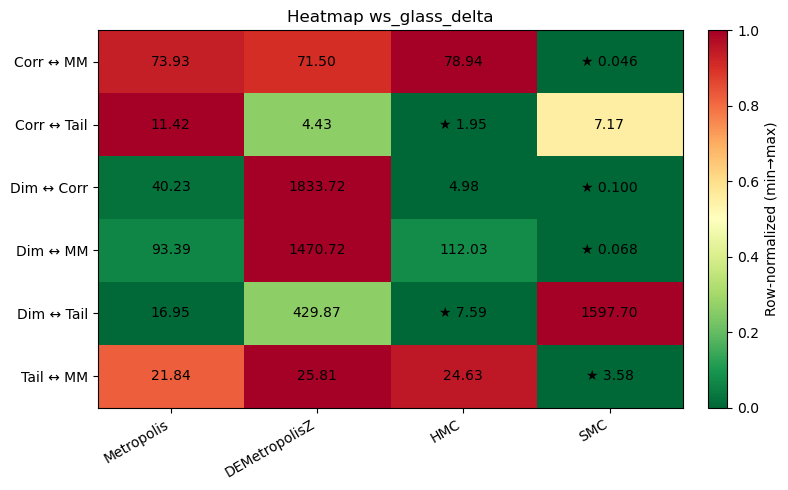

In [54]:
EXPERIMENTS_ROOT = Path("/home/fabian/python_files/MA/experiments")  
print("Available experiments:", sorted(p.name for p in EXPERIMENTS_ROOT.iterdir() if p.is_dir()))

experiment_name = "thesis_run" 
exp_path = EXPERIMENTS_ROOT / f"exp_{experiment_name}"  


pivot, winners = generate_heatmaps_for_experiment(
    experiment_path=exp_path,
    metric=resolve_metric("ws_delta"),   # Glass' Δ (↓ better)
    which_results="chain",
    agg="mean",
    normalize="row",                    # absolute values (robust P5–P95)
    combo_spec="combo_spec_2.yaml",      # your pair combos
    dir_reduce="mean",                   # mean over directions (A|B and B|A)
    metric_goal="low",
    strict_combos="error",               # fail fast on typos/missing patterns
    unmatched_policy="drop",             # use YAML-only
    out_subdir="heatmaps",
    save=True,
    cmap="auto",                         # green = best for low-is-better
    cap_max=1000,
    vmax_mode="max_below_cap",
    show_star=True,              # <<< omit ★
    show_status=False           # <<< omit (k/m)
)
